In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic 1D data
np.random.seed(42)
X = np.concatenate([
    np.random.normal(loc=5, scale=1.0, size=200),
    np.random.normal(loc=15, scale=1.5, size=150),
    np.random.normal(loc=25, scale=2.0, size=100)
]).reshape(-1, 1)

In [2]:
class GaussianMixtureModel:
    def __init__(self, n_components=3, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights_ = None
        self.means_ = None
        self.covariances_ = None
        
    def fit(self, X):
        n_samples, n_features = X.shape
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = np.array([np.eye(n_features)] * self.n_components)
        
        log_likelihood_old = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step: Calculate responsibilities
            responsibilities = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                responsibilities[:, k] = self.weights_[k] * self._gaussian_pdf(
                    X, self.means_[k], self.covariances_[k])
            responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
            N_k = responsibilities.sum(axis=0)
            self.weights_ = N_k / n_samples
            
            for k in range(self.n_components):
                self.means_[k] = np.sum(responsibilities[:, k:k+1] * X, axis=0) / N_k[k]
            
            for k in range(self.n_components):
                diff = X - self.means_[k]
                self.covariances_[k] = np.dot(
                    responsibilities[:, k] * diff.T, diff) / N_k[k]
                # Add small value for numerical stability
                self.covariances_[k] += 1e-6 * np.eye(n_features)
            
            log_likelihood = 0
            for k in range(self.n_components):
                log_likelihood += np.sum(responsibilities[:, k] * (
                    np.log(self.weights_[k] + 1e-100) + 
                    self._log_gaussian_pdf(X, self.means_[k], self.covariances_[k])))
            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                print(f"Converged at iteration {iteration}")
                break
            
            log_likelihood_old = log_likelihood
        self.labels_ = responsibilities.argmax(axis=1)
        return self
    
    def _gaussian_pdf(self, X, mean, cov):
        """Calculate Gaussian probability density function"""
        n_features = X.shape[1]
        diff = X - mean
        exponent = -0.5 * np.sum(diff @ np.linalg.inv(cov) * diff, axis=1)
        norm_const = 1 / np.sqrt((2 * np.pi) ** n_features * np.linalg.det(cov))
        return norm_const * np.exp(exponent)
    
    def _log_gaussian_pdf(self, X, mean, cov):
        """Calculate log of Gaussian PDF (more stable)"""
        n_features = X.shape[1]
        diff = X - mean
        inv_cov = np.linalg.inv(cov)
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
        norm_const = -0.5 * (n_features * np.log(2 * np.pi) + np.log(np.linalg.det(cov)))
        return norm_const + exponent
    
    def predict(self, X):
        """Predict cluster assignments for new data"""
        responsibilities = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights_[k] * self._gaussian_pdf(
                X, self.means_[k], self.covariances_[k])
        return responsibilities.argmax(axis=1)

In [3]:
gmm = GaussianMixtureModel(n_components=3)
gmm.fit(X)
labels = gmm.labels_

Converged at iteration 13


C:\Users\joanf\AppData\Local\Temp\ipykernel_14472\91300889.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


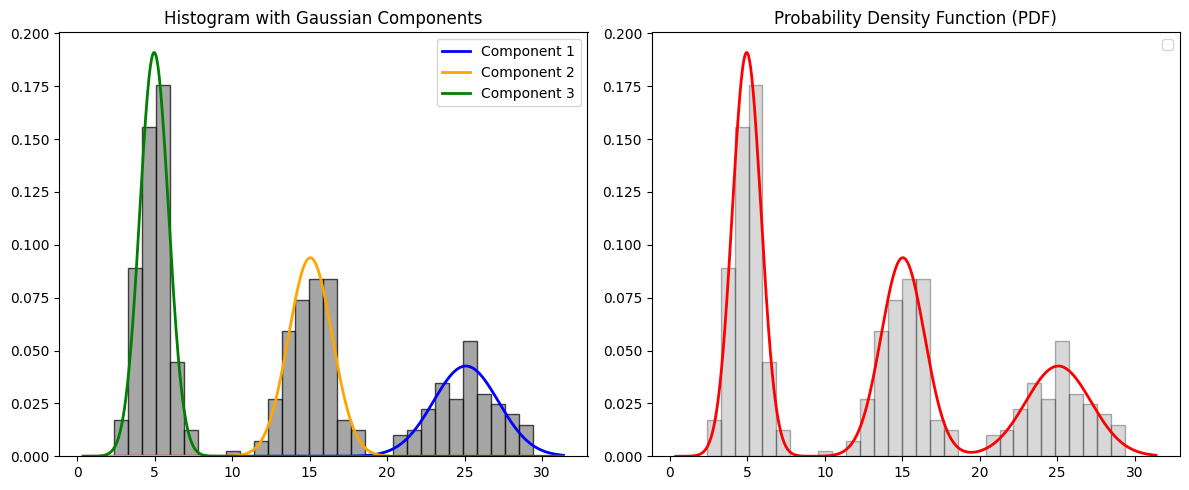

Gaussian Mixture Model completed successfully!
Component weights: [0.22480708 0.33074827 0.44444465]
Component means: [25.07809634 15.0395834   4.95923224]


In [4]:
x_range = np.linspace(X.min() - 2, X.max() + 2, 1000).reshape(-1, 1)

# Calculate overall PDF
pdf_values = np.zeros(x_range.shape[0])   # (1000,)
for k in range(gmm.n_components):
    pdf_values += (
        gmm.weights_[k]
        * gmm._gaussian_pdf(x_range, gmm.means_[k], gmm.covariances_[k])
    )


# Create a 2x2 figure layout
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram with Gaussian Components
axes[0].hist(X, bins=30, density=True, color='gray', alpha=0.7, edgecolor='black')
colors = ['blue', 'orange', 'green']
for k in range(gmm.n_components):
    # Calculate individual Gaussian PDF
    gaussian_pdf = gmm._gaussian_pdf(x_range, gmm.means_[k], gmm.covariances_[k])
    axes[0].plot(x_range, gaussian_pdf * gmm.weights_[k], 
                   color=colors[k], linewidth=2, label=f'Component {k+1}')
axes[0].set_title('Histogram with Gaussian Components')
axes[0].legend()

# Probability Density Function (PDF)
axes[1].plot(x_range.flatten(), pdf_values, color='red', linewidth=2)
axes[1].hist(X, bins=30, density=True, color='gray', alpha=0.3, edgecolor='black')
axes[1].set_title('Probability Density Function (PDF)')
axes[1].legend()

plt.tight_layout()
plt.savefig("./figures/distribution.jpg")
plt.show()

print("Gaussian Mixture Model completed successfully!")
print(f"Component weights: {gmm.weights_}")
print(f"Component means: {gmm.means_.flatten()}")